## Cython

<https://doc.sagemath.org/html/en/thematic_tutorials/cython_interface.html>

<https://doc.sagemath.org/html/en/developer/coding_in_cython.html>

In [1]:
# Ignore this; my laptop is so old and Apple is nasty so I need this
sdkroot = !xcrun --show-sdk-path
%env SDKROOT={sdkroot[0]}

env: SDKROOT=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk


In [11]:
%%bash
brew install pkg-config

To reinstall 2.5.1, run:
  brew reinstall pkgconf


In [6]:
%%bash
cat > hello.c << CCODE

#include <stdio.h>
void hello_world(){
    printf("Hello World\n");
}

CCODE

In [7]:
%%cython

cdef extern from "hello.c":
    void hello_world()

def my_bridge_function():
    hello_world() # This is the C function from hello.c

RuntimeError: command '/usr/bin/clang' failed with exit code 1
clang: error: SDK "$(xcrun --show-sdk-path)" cannot be located
In file included from /var/folders/3p/r_29jkjx76b9g_qktgdtf6_w0000gn/T/sage_ffhlhs6u/spyx_uuvq9gy1/_var_folders_3p_r_29jkjx76b9g_qktgdtf6_w0000gn_T_sage_ffhlhs6u_tmp_jafsmbe9_pyx/_var_folders_3p_r_29jkjx76b9g_qktgdtf6_w0000gn_T_sage_ffhlhs6u_tmp_jafsmbe9_pyx_0.c:46:
/private/var/tmp/sage-10.6-current/local/var/lib/sage/venv-python3.12.5/include/python3.12/Python.h:23:12: fatal error: 'stdlib.h' file not found
#  include <stdlib.h>
           ^~~~~~~~~~
1 error generated.

In [13]:
%%cython
def is2pow(n):
    while n != 0 and n % 2 == 0:
        n >>= 1
    return n == 1

RuntimeError: command '/usr/bin/clang' failed with exit code 1
clang: error: SDK "$(xcrun --show-sdk-path)" cannot be located
In file included from /var/folders/3p/r_29jkjx76b9g_qktgdtf6_w0000gn/T/sage_ffhlhs6u/spyx_uuvq9gy1/_var_folders_3p_r_29jkjx76b9g_qktgdtf6_w0000gn_T_sage_ffhlhs6u_tmp_8eij2y1s_pyx/_var_folders_3p_r_29jkjx76b9g_qktgdtf6_w0000gn_T_sage_ffhlhs6u_tmp_8eij2y1s_pyx_0.c:45:
/private/var/tmp/sage-10.6-current/local/var/lib/sage/venv-python3.12.5/include/python3.12/Python.h:23:12: fatal error: 'stdlib.h' file not found
#  include <stdlib.h>
           ^~~~~~~~~~
1 error generated.

In [1]:
%%bash
cat > ispow2.spyx << CYTHONCODE

def is2pow(n):
    while n != 0 and n%2 == 0:
        n = n >> 1
    return n == 1

CYTHONCODE

In [10]:
# set up a sane toolchain for this session
%env CC=clang
%env CXX=clang++
%env SDKROOT=$(xcrun --show-sdk-path)
%env LDFLAGS=
%env CFLAGS=-mmacosx-version-min=12.0
%env LDSHARED="clang -bundle -undefined dynamic_lookup"

env: CC=clang
env: CXX=clang++
env: SDKROOT=$(xcrun --show-sdk-path)
env: LDFLAGS=
env: CFLAGS=-mmacosx-version-min=12.0
env: LDSHARED="clang -bundle -undefined dynamic_lookup"


In [11]:
load('ispow2.spyx')

Compiling ispow2.spyx...


RuntimeError: command '/usr/bin/clang' failed with exit code 1
clang: error: SDK "$(xcrun --show-sdk-path)" cannot be located
In file included from /var/folders/3p/r_29jkjx76b9g_qktgdtf6_w0000gn/T/sage_ffhlhs6u/spyx_uuvq9gy1/_Users_ThinBold_Git_ccpppy2025_slides_1112_ispow2_spyx/_Users_ThinBold_Git_ccpppy2025_slides_1112_ispow2_spyx_4.c:45:
/private/var/tmp/sage-10.6-current/local/var/lib/sage/venv-python3.12.5/include/python3.12/Python.h:23:12: fatal error: 'stdlib.h' file not found
#  include <stdlib.h>
           ^~~~~~~~~~
1 error generated.

In [14]:
attach("ispow2.spyx")

AttributeError: 'SageZMQInteractiveShell' object has no attribute '_inputhook'

In [12]:
%%cython
import numpy as np
cimport numpy as np
def envelope(double [:] f):
    cdef int f_len = f.shape[0]
    cdef int [:] boundary = np.zeros(f_len, "intc")
    boundary[0] = 0
    boundary[1] = 1
    cdef int b_len = 2
    cdef int i, j, k = 2
    cdef bint modified = False
    while(k < f_len):
        i = boundary[b_len-2]
        j = boundary[b_len-1]
        # compare slopes
        if (f[k] - f[j]) / (k - j) >= (f[j] - f[i]) / (j - i):
            # still convex, push k to boundary
            boundary[b_len] = k
            b_len += 1
            k += 1
        else:
            # not convex anymore, pop j
            modified = True
            b_len -= 1
            if b_len == 1:
                boundary[b_len] = k
                b_len += 1
                k += 1
    if not modified:
        return (0, None)
    # some points are modified; complete convex hull
    g_python = np.zeros(f_len, "double")
    cdef double [:] g = g_python
    cdef int a
    cdef double fi, slope
    cdef double fj, gj, fj_gj
    cdef double descent_max = 0.
    for a in range(b_len - 1):
        i = boundary[a]
        k = boundary[a + 1]
        g[i] = fi = f[i]
        slope = (f[k] - fi) / (k - i)
        for j in range(i + 1, k):
            # update points not in hull
            gj = fi + slope * (j - i)
            fj = f[j]
            fj_gj =  fj - gj
            if fj_gj < 0: #rounding error; keep fj
                g[j] = fj
            else: # actual progress
                g[j] = gj
                descent_max = max(descent_max, fj_gj)
    g[f_len - 1] = f[f_len - 1]
    return (descent_max, g_python)

RuntimeError: command '/usr/bin/clang' failed with exit code 1
clang: error: SDK "$(xcrun --show-sdk-path)" cannot be located
In file included from /var/folders/3p/r_29jkjx76b9g_qktgdtf6_w0000gn/T/sage_ffhlhs6u/spyx_uuvq9gy1/_var_folders_3p_r_29jkjx76b9g_qktgdtf6_w0000gn_T_sage_ffhlhs6u_tmp_fg3h6jyt_pyx/_var_folders_3p_r_29jkjx76b9g_qktgdtf6_w0000gn_T_sage_ffhlhs6u_tmp_fg3h6jyt_pyx_0.c:46:
/private/var/tmp/sage-10.6-current/local/var/lib/sage/venv-python3.12.5/include/python3.12/Python.h:23:12: fatal error: 'stdlib.h' file not found
#  include <stdlib.h>
           ^~~~~~~~~~
1 error generated.

In [2]:
f = lambda t: (t,t^2,t^3)
t = Tachyon(camera_center=(5,0,4))
t.texture('t')
t.light((-20,-20,40), 0.2, (1,1,1))
t.parametric_plot(f,-5,5,'t',min_depth=6)

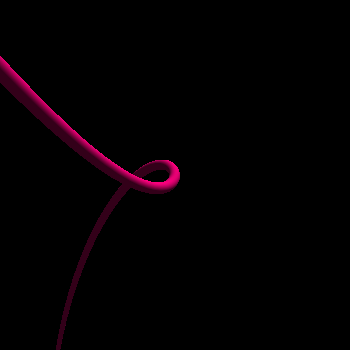

In [3]:
t